Optimization of Coulomb force evaluation



In [1]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import time

In [3]:
def measure_time(num_ptcls, per_ptcl_charges=False, num_iter=1, use_reference_impl=False):
    ensemble = coldatoms.Ensemble(num_ptcls=num_ptcls)
    ensemble.x = np.random.random([num_ptcls, 3])
    if per_ptcl_charges:
        ensemble.set_particle_properties('charge', np.random.random(num_ptcls))
    else:
        ensemble.ensemble_properties['charge'] = 1.0
    
    f = coldatoms.CoulombForce()
    if use_reference_impl:
        f.use_reference_implementations()
        
    t0 = time.time()
    for i in range(num_iter):
        f.force(1.0e-1, ensemble)
    t1 = time.time()
    return t1 - t0

In [4]:
def num_ptcls(n_min, n_max, n):
    return [n_min * (n_max / n_min)**(i/(n - 1)) for i in range(n)]

Here is the naive C implementation

<IPython.core.display.Javascript object>


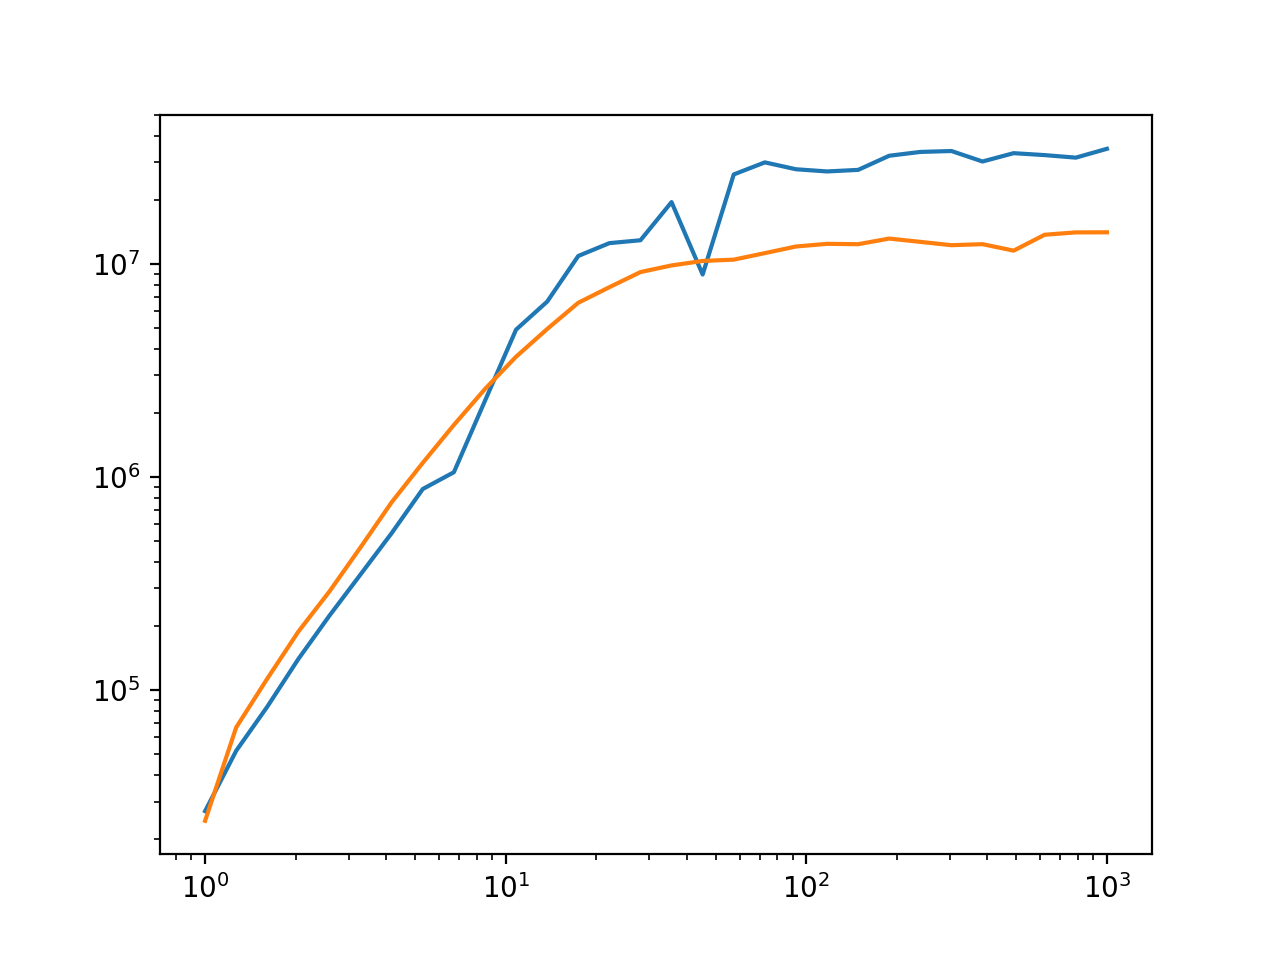

In [8]:
nptcls = np.array(num_ptcls(1, 1000, 30))
times = np.array([measure_time(int(round(n)), num_iter=5) for n in nptcls])
pairs_per_second = nptcls**2 / times
plt.figure()
plt.loglog(nptcls, pairs_per_second)
pps_base_c = np.array([    24385.48837209,     66870.57884403,    113287.44313781,
          188307.06362248,    290719.64338937,    468134.80241597,
          761671.98461132,   1165774.07455993,   1755531.2428043 ,
         2587300.44268084,   3668771.16041333,   4947684.41821783,
         6570778.01485452,   7775192.49923251,   9155971.38770515,
         9838092.81225736,  10325869.68439306,  10470944.88549793,
        11234960.46172568,  12068955.60224354,  12421286.14435947,
        12373259.95266295,  13148948.84724044,  12688095.88608003,
        12241007.20712971,  12377054.72497589,  11541078.03485713,
        13705085.62287561,  14056468.21965703,  14069227.38906276])
plt.loglog(nptcls, pps_base_c)

The latency can be inferred from the time it takes to deal with just one pair:

In [64]:
times[0]

4.0292739868164062e-05

In [66]:
pairs_per_second[-1]

14071681.87018355

For the numbers of particles considered here we do not observe any cache effects yet. This could be due to inefficiencies in the force evaluation function or due to the relatively small number of particles (Easily fits in L2, almost fits into L1 cache). We can model the processing speed using latency and the processing speed at large numbers of particles.

In [68]:
def const_rate_model(latency, rate, num_ptcls):
    num_pairs = num_ptcls**2
    total_time = latency + num_pairs / rate
    return num_pairs / total_time

<IPython.core.display.Javascript object>


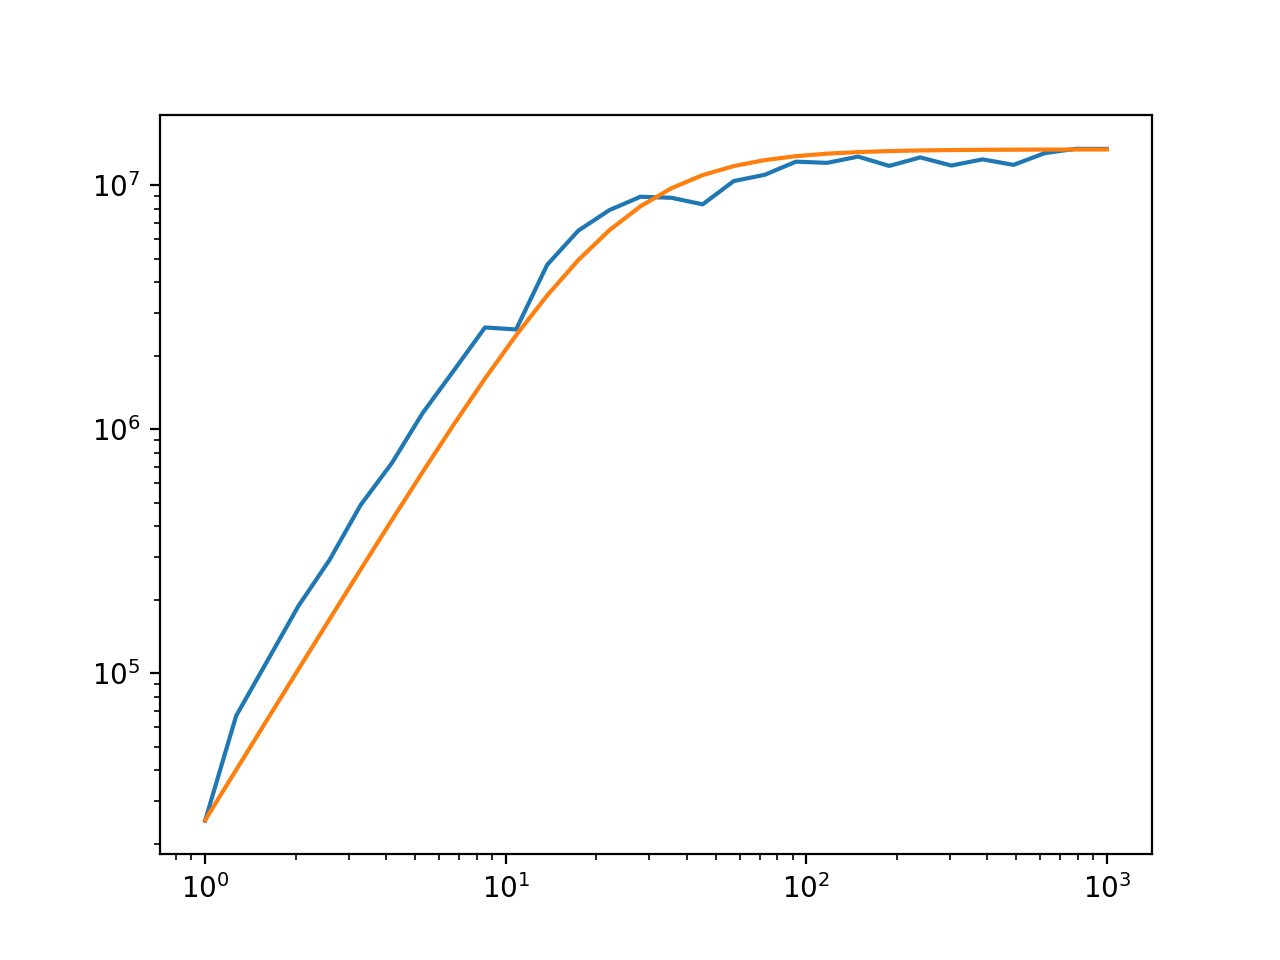

In [69]:
plt.figure()
plt.loglog(nptcls, pairs_per_second)
plt.loglog(nptcls, [const_rate_model(4.0e-5, 1.4e7, n) for n in nptcls])

Here is the reference implementation in python

<IPython.core.display.Javascript object>


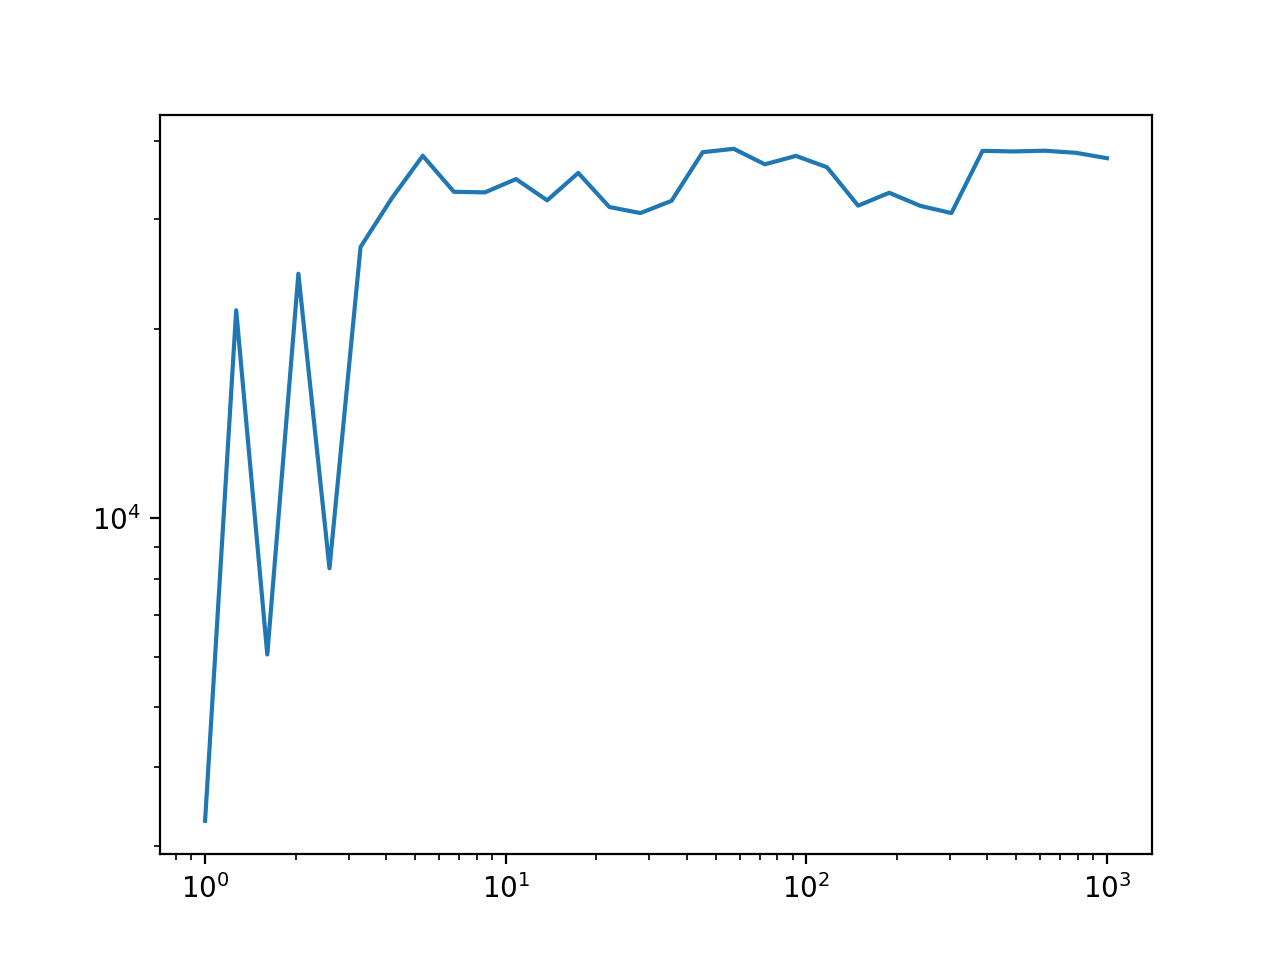

In [73]:
nptcls = np.array(num_ptcls(1, 1000, 30))
times = np.array([measure_time(int(round(n)), num_iter=5, use_reference_impl=True) for n in nptcls])
pairs_per_second = nptcls**2 / times
plt.figure()
plt.loglog(nptcls, pairs_per_second)

Using the reference implementation the asymptotic rate of computing pariwise interactions is almost three orders of magnitude lower.

In [76]:
times[0]

0.00030422210693359375

In [12]:
pps_base_c = np.array([    24385.48837209,     66870.57884403,    113287.44313781,
          188307.06362248,    290719.64338937,    468134.80241597,
          761671.98461132,   1165774.07455993,   1755531.2428043 ,
         2587300.44268084,   3668771.16041333,   4947684.41821783,
         6570778.01485452,   7775192.49923251,   9155971.38770515,
         9838092.81225736,  10325869.68439306,  10470944.88549793,
        11234960.46172568,  12068955.60224354,  12421286.14435947,
        12373259.95266295,  13148948.84724044,  12688095.88608003,
        12241007.20712971,  12377054.72497589,  11541078.03485713,
        13705085.62287561,  14056468.21965703,  14069227.38906276])

In [13]:
pps_base_c_O3_native = np.array([    24244.53179191,     64323.1282214 ,    107679.15387356,
          173391.65264249,    281998.05408769,    468134.80241597,
          723965.45071967,   1132145.97625532,   1663134.86160407,
         2403948.44280582,   3536800.97478696,   4827009.1885052 ,
         6503729.25960091,   7775192.49923251,   9055631.97523715,
         9748000.38723669,   9965664.92796075,  11386720.5933055 ,
        12183526.20246348,  12490210.59708625,  12197787.13456468,
        12748979.99244566,  13067299.78583113,  11893404.23114586,
        13028067.29321883,  12918898.49247158,  13108371.91366755,
        13699746.31076073,  13840979.02887266,  14120476.57362551])

In [14]:
pps_tiled=np.array([  2.70600258e+04,   5.19532959e+04,   8.36584195e+04,
         1.40100455e+05,   2.23807979e+05,   3.49300583e+05,
         5.45675452e+05,   8.78680459e+05,   1.05331875e+06,
         2.27836905e+06,   4.91615335e+06,   6.65234880e+06,
         1.08951362e+07,   1.25161635e+07,   1.29113503e+07,
         1.94960008e+07,   8.91828495e+06,   2.62870578e+07,
         2.99498003e+07,   2.78045481e+07,   2.71547344e+07,
         2.76152013e+07,   3.21730202e+07,   3.35272679e+07,
         3.38590838e+07,   3.02306983e+07,   3.30813072e+07,
         3.23944376e+07,   3.15205703e+07,   3.46800063e+07])

In [15]:
pps_reference = np.array([  3287.07210031,  21441.04274047,   6055.45353075,  24527.3906399 ,
         8311.17165009,  27061.42779163,  32339.89850627,  37835.21257409,
        33140.60028367,  33069.91467031,  34728.40742409,  32114.78729878,
        35517.71899921,  31338.65890773,  30648.66865373,  32057.48589947,
        38326.22379157,  38810.83317843,  36660.74172438,  37812.36849543,
        36268.36643763,  31493.76108758,  33020.00755627,  31469.83940433,
        30647.48845493,  38517.65057798,  38435.95488974,  38540.32874678,
        38244.94813284,  37494.41937717])

In [16]:
pairs_per_second

array([  2.70600258e+04,   5.19532959e+04,   8.36584195e+04,
         1.40100455e+05,   2.23807979e+05,   3.49300583e+05,
         5.45675452e+05,   8.78680459e+05,   1.05331875e+06,
         2.27836905e+06,   4.91615335e+06,   6.65234880e+06,
         1.08951362e+07,   1.25161635e+07,   1.29113503e+07,
         1.94960008e+07,   8.91828495e+06,   2.62870578e+07,
         2.99498003e+07,   2.78045481e+07,   2.71547344e+07,
         2.76152013e+07,   3.21730202e+07,   3.35272679e+07,
         3.38590838e+07,   3.02306983e+07,   3.30813072e+07,
         3.23944376e+07,   3.15205703e+07,   3.46800063e+07])

<IPython.core.display.Javascript object>


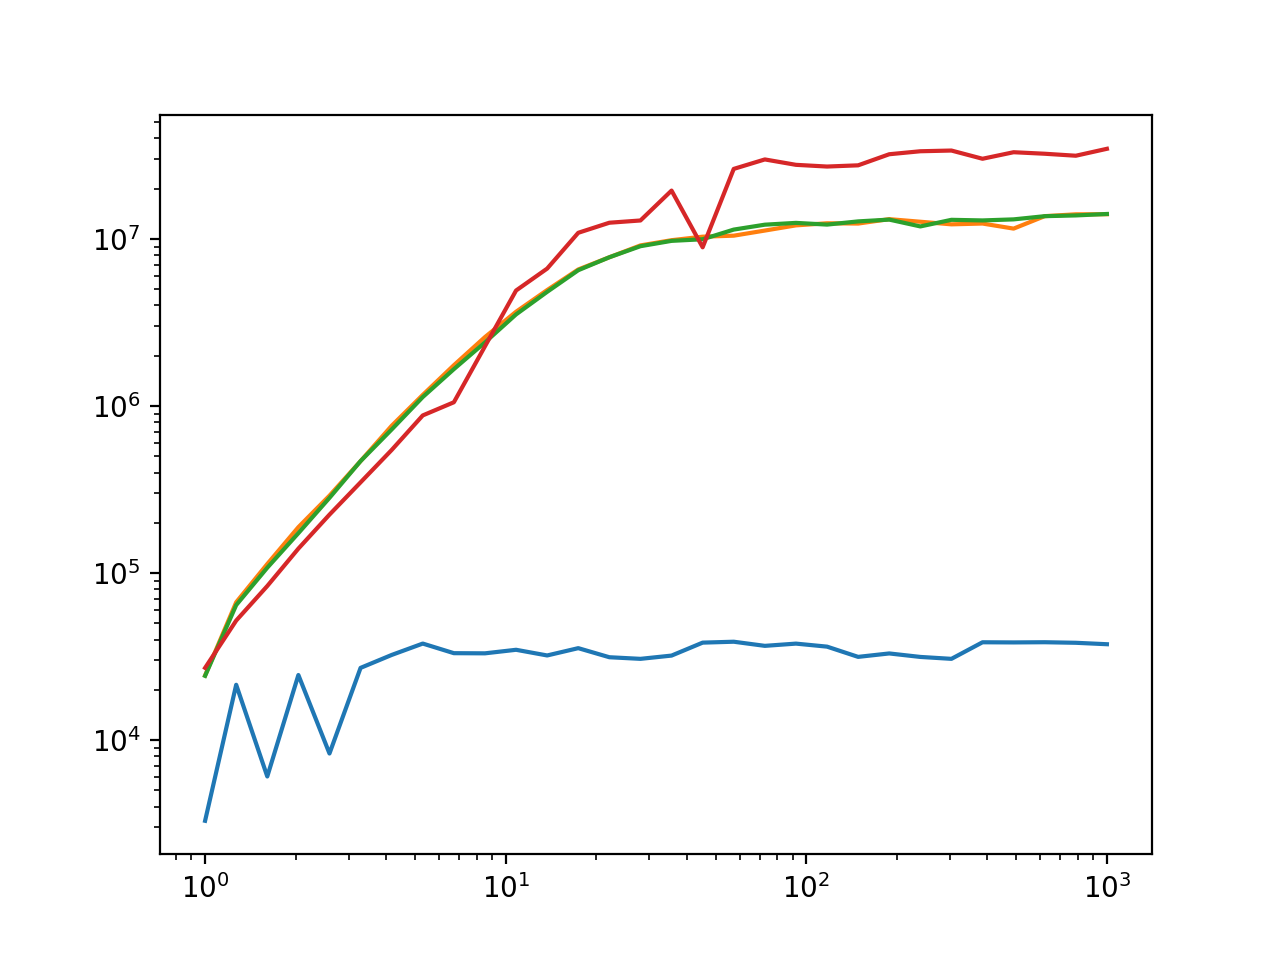

In [17]:
plt.figure()
for data in [pps_reference, pps_base_c, pps_base_c_O3_native, pps_tiled]:
    plt.loglog(nptcls, data)

In [ ]:
127**2 / 